# summary data 
- record 04015 ([1:8])
- record 04043 ([1:16])
- record 04048 ([1:6])
- record 04126 ([1:])
- record 04746 (tidak di proses, karena kebanyakan data N)
- record 04908 ([1:]) -> annotate.txt nya di custom
- record 04936 ([4:])
- record 05091 ([1:])
- record 05121 ([1:])
- record 05261 ([1:18])
- record 06426 ([1:])
- record 06453 ([1:])
- record 06995 ([1:])
- record 07162 (tidak di proses, isinya hanya AF)
- record 07859 (tidak di proses, isinya hanya AF)
- record 07879 (tidak di proses, karena kebanyakan data N)
- record 07910 ([1:10])
- record 08215 ([1:])
- record 08219 ([1:])
- record 08378 ([5:])
- record 08405 (tidak di proses, karena kebanyakan data N)
- record 08434 (tidak di proses, karena semua data N)
- record 08455 ([1:])

In [56]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
record = "08455"

In [58]:
dataset_dir = "dataset/AFDB record_%s/" % record

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['DATA.csv']

- Read Annotation file

In [59]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [60]:
annotations

['      Time   Sample #  Type  Sub Chan  Num\tAux\n',
 ' 3:07:13.584  2808396     +    0    0    0\t(AFIB\n',
 ' 3:08:02.972  2820743     +    0    0    0\t(N\n',
 ' 3:10:01.404  2850351     +    0    0    0\t(AFIB\n']

In [63]:
label_idx = []
for item in annotations[1:] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [64]:
label_idx

[['3:07:13.584', 'AFIB'], ['3:08:02.972', 'N'], ['3:10:01.404', 'AFIB']]

- Read & formatting ECG data

In [65]:
def read_csv_to_df(filename, folder, sep=";"):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [66]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [67]:
df_ecg.head(10)

,ECG1,ECG2
Time,,
2020-12-14 03:05:00.000,-0.290,0.075
2020-12-14 03:05:00.004,-0.405,0.070
2020-12-14 03:05:00.008,-0.370,0.080
2020-12-14 03:05:00.012,-0.255,0.095
2020-12-14 03:05:00.016,-0.290,0.075
2020-12-14 03:05:00.020,-0.410,0.050
2020-12-14 03:05:00.024,-0.390,0.070
2020-12-14 03:05:00.028,-0.275,0.070
2020-12-14 03:05:00.032,-0.295,0.000


- plot signal 

In [68]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    
    plt.ylim([-2.1, 2.1])
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

In [69]:
fs = 250 #hz

03:05:00 03:05:16


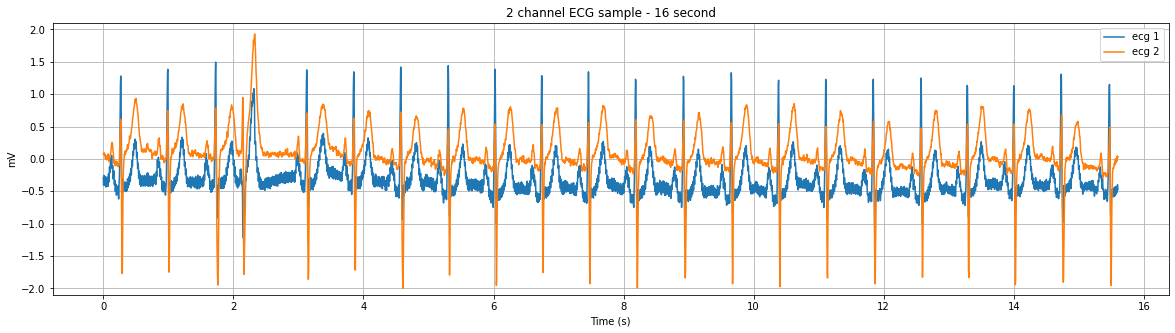

In [70]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 16 second")

- Split Normal (N) and AFIB data

In [71]:
label_idx

[['3:07:13.584', 'AFIB'], ['3:08:02.972', 'N'], ['3:10:01.404', 'AFIB']]

In [72]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    else :
        AFIB_range.append([tm, next_tm])

In [73]:
AFIB_range

[[Timestamp('2020-12-14 03:07:13.584000'),
  Timestamp('2020-12-14 03:08:02.972000')]]

In [74]:
N = []
for nr in N_range :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [75]:
AFIB = []
for ar in AFIB_range :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [76]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [77]:
def plot_16s_sample(data, label="2 channel ECG plot - 16s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["ecg1", "ecg2"])
    plt.grid(True)
    plt.show()

In [78]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [79]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [80]:
time_interval_N = []
for N_item in N:
    intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=16))]
    time_interval_N.append(intr)

In [81]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=16))]
    time_interval_AFIB.append(intr)

In [82]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('N')
        
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('AF')

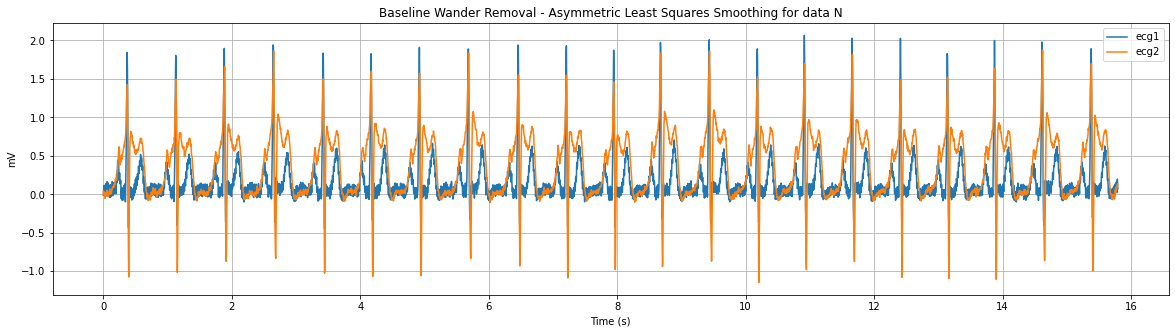

In [83]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

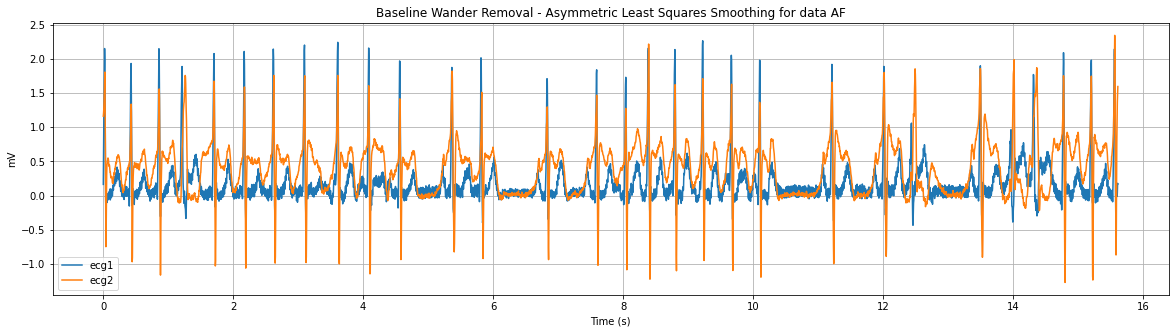

In [84]:
idx = -1
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- Signal normalization from -1 to 1

In [85]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [86]:
#scaler = scaler = StandardScaler(with_mean=False, with_std=False) 
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

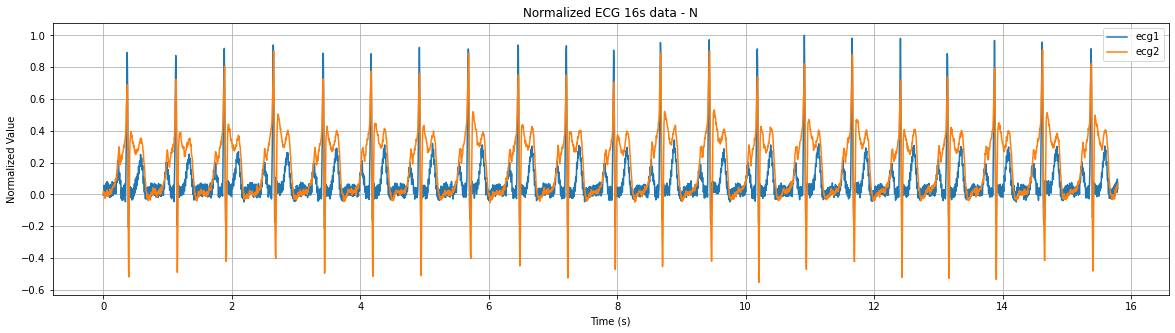

In [87]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

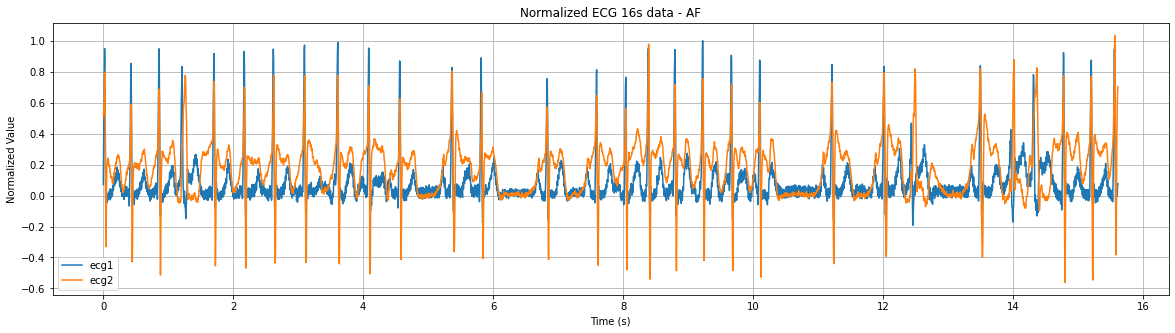

In [88]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- QRS Detection

In [89]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [90]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

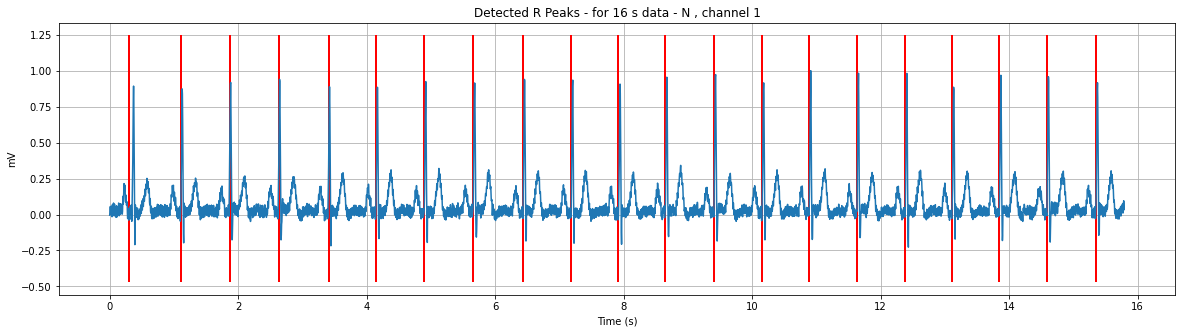

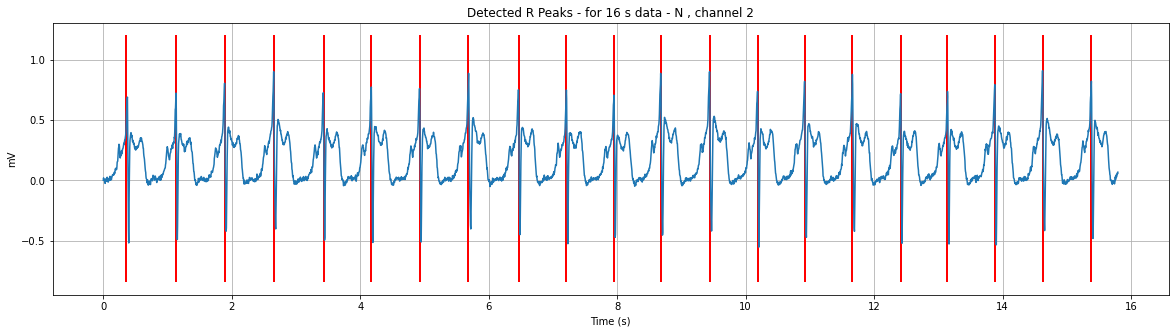

In [91]:
idx = 0

data = np.array(ECG_ALS_Norm[idx])

for ch in range(0,2):
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

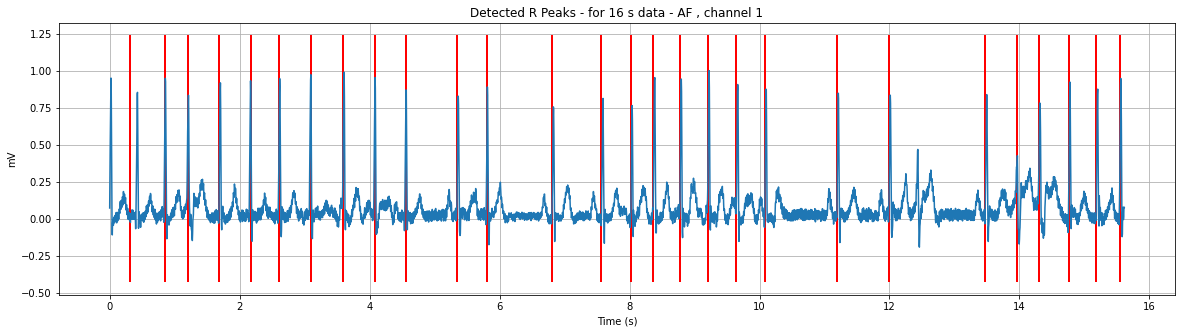

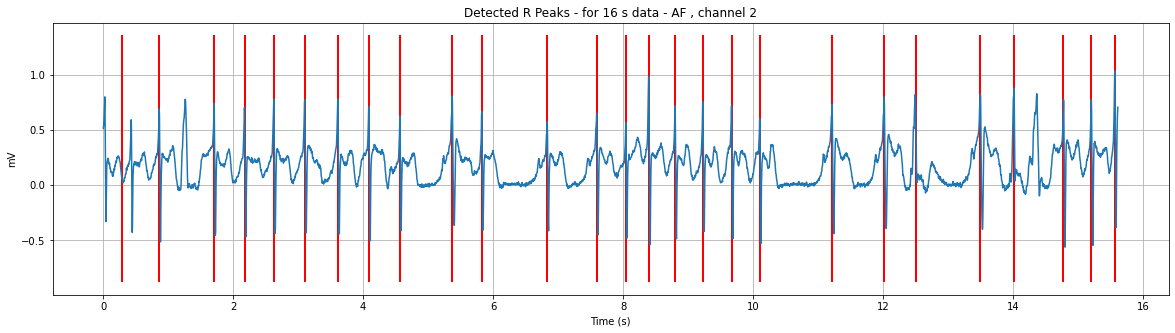

In [92]:
idx = -1

data = np.array(ECG_ALS_Norm[idx])

for ch in [0, 1]:
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [93]:
ECG_split = []
ECG_split_label = []
for i in range(len(ECG_ALS_Norm)) :
    data = np.array(ECG_ALS_Norm[i])
    if len(data) > 0:
        r_peaks = []
        try :
            r_peaks = detectors.christov_detector(data[0])
        except :
            print("cannot find R peaks in ALS Norm, idx %d" % i)
        RRs = np.diff(r_peaks)
        RRs_med = np.median(RRs)
        if not np.isnan(RRs_med) and RRs_med > 0:
            for rp in r_peaks :
                split1 = data[0][:,0][rp : rp + int(RRs_med * 1.2)] 
                split2 = data[1][:,0][rp : rp + int(RRs_med * 1.2)] 
                
                n1 = len(split1) if len(split1) <= 300 else 300
                n2 = len(split2) if len(split2) <= 300 else 300
                pad1 = np.zeros(300)
                pad2 = np.copy(pad1)
                pad1[0:n1] = split1[0:n1]
                pad2[0:n2] = split2[0:n2]
                ECG_split.append([pad1, pad2])
                ECG_split_label.append(ECG_ALS_label[i])


In [94]:
def plot_1_sample(data, label, fs):
    ecg1 = data[0]
    ecg2 = data[1]
    times = np.arange(ecg1.shape[0]) / fs * 1000 

    label = 'Normal' if label == 'N' else 'Atrial Fibrillation'
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title("Plot 1 Sample (%dHz) : %s Beat" % (fs, label))
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

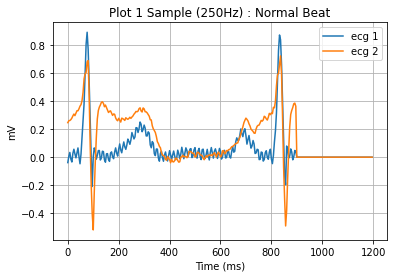

In [95]:
idx = 0
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

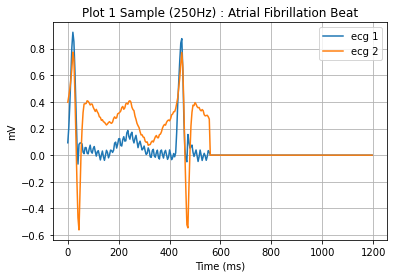

In [96]:
idx = -3
plot_1_sample(ECG_split[idx], ECG_split_label[idx], fs)

In [97]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i][0])
    x.extend(list(ECG_split[i][1]))
    x.append(ECG_split_label[i])
    data.append(x)

In [98]:
ECG = pd.DataFrame(data)

In [99]:
ECG.tail()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
228,0.425309,0.295338,0.065514,-0.065475,-0.073376,-0.077452,-0.148384,-0.171369,-0.139784,-0.082318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
229,0.354054,0.513639,0.690807,0.781752,0.777611,0.720301,0.585495,0.326779,0.069967,-0.039257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
230,0.093051,0.210148,0.382370,0.598698,0.810570,0.923054,0.852254,0.635713,0.355129,0.089989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
231,0.018288,0.174731,0.388566,0.556024,0.710234,0.842369,0.875149,0.638551,0.282716,0.048310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF
232,0.127022,0.259434,0.460385,0.712214,0.906731,0.946778,0.869887,0.656176,0.336540,0.025781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AF


In [100]:
ECG.to_csv("dataset/AFDB_%s_sequence_300_pt_2_ch.csv" % record, index=False, header=False)